- Ways to apply fine tuning :

- **full fine tuning** : train all internal model parameters (called full parameter tuning). While this option is simple (conceptually), it is the most computationally expensive. Additionally, a known issue with full parameter tuning is the phenomenon of **catastrophic forgetting.**

- **transfer learning** :The big idea with transfer learning (TL) is to preserve the useful representations/features the model has learned from past training when applying the model to a new task. This generally consists of dropping “the head” of a neural network (NN) and replacing it with a new one (e.g. adding new layers with randomized weights).

- **Parameter Efficient Fine tuning** : PEFT involves augmenting a base model with a relatively small number of trainable parameters. The key result of this is a fine-tuning methodology that demonstrates comparable performance to full parameter tuning at a tiny fraction of the computational and storage cost.


- LORA : PEFT encapsulates a family of techniques, one of which is the popular LoRA (Low-Rank Adaptation) method.

- The basic idea behind LoRA is to pick a subset of layers in an existing model and modify their weights according to the following equation.




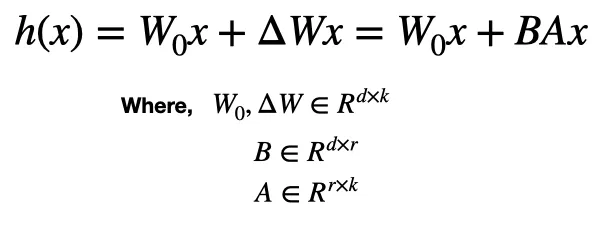


# Installation

In [ ]:
! pip install torch
! pip install accelerate
! pip install sacremoses
! pip install transformers datasets
! pip install evaluate sacrebleu loralib
! pip install -q git+https://github.com/huggingface/peft.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 13.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Translation

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

## Load dataset

In [ ]:
from datasets import Dataset, DatasetDict, load_dataset

# Read your text file
with open('/content/drive/MyDrive/en_ar_custom_data.txt', 'r') as file:
    lines = file.readlines()

# Structure of your dataset
dataset_structure = {'translation': [{'ar': line.split('\t')[1].strip(), 'en': line.split('\t')[0].strip()} for line in lines]}

# Split
train_size = int(0.91 * len(lines))
valid_size = len(lines) - train_size
train_dataset = Dataset.from_dict({key: value[:train_size] for key, value in dataset_structure.items()})
valid_dataset = Dataset.from_dict({key: value[-valid_size:] for key, value in dataset_structure.items()})

# Create a DatasetDict for your first dataset
raw_dataset_1 = DatasetDict({'train': train_dataset, 'validation': valid_dataset})

opus = load_dataset("opus100", "ar-en")

# Add all samples from raw_dataset_1 to opus["train"]
opus_train_dataset = Dataset.from_dict({
    'translation': list(raw_dataset_1['train']['translation']) + list(raw_dataset_1['validation']['translation'])+ list(opus['train']['translation'])})

# Use opus["validation"]
opus_valid_dataset = opus['validation']

# Create a new DatasetDict with the merged 'train' and 'validation' splits
merged_dataset = DatasetDict({
    'train': opus_train_dataset,
    'validation': opus_valid_dataset,
})

# Print information about the updated dataset
print(merged_dataset)


DatasetDict({
    train: Dataset({
        features: ['translation'],
        num_rows: 1026167
    })
    validation: Dataset({
        features: ['translation'],
        num_rows: 2000
    })
})


In [ ]:
train = merged_dataset["train"].shuffle(seed=42).select(range(60000))
validation = merged_dataset["validation"].shuffle(seed=42).select(range(2000))

## Preprocess

The next step is to load a model & tokenizer to process (ar-en) language pairs:

In [ ]:
from transformers import AutoTokenizer
checkpoint = "Helsinki-NLP/opus-mt-ar-en"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [ ]:
from transformers import AutoModelForSeq2SeqLM, Seq2SeqTrainingArguments, Seq2SeqTrainer
model = AutoModelForSeq2SeqLM.from_pretrained(checkpoint)

pytorch_model.bin:   0%|          | 0.00/308M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

In [ ]:
print(model)

MarianMTModel(
  (model): MarianModel(
    (shared): Embedding(62834, 512, padding_idx=62833)
    (encoder): MarianEncoder(
      (embed_tokens): Embedding(62834, 512, padding_idx=62833)
      (embed_positions): MarianSinusoidalPositionalEmbedding(512, 512)
      (layers): ModuleList(
        (0-5): 6 x MarianEncoderLayer(
          (self_attn): MarianAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation_fn): SiLU()
          (fc1): Linear(in_features=512, out_features=2048, bias=True)
          (fc2): Linear(in_features=2048, out_features=512, bias=True)
          (final_layer_norm): LayerNorm((512,), eps=1e-05

# Freeze model weights

In [ ]:
# Freeze all layers in the encoder
for layer in model.model.encoder.layers:
    for parameter in layer.parameters():
        parameter.requires_grad = False

# Freeze all layers in the decoder
for layer in model.model.decoder.layers:
    for parameter in layer.parameters():
        parameter.requires_grad = False


# Lora Config

In [ ]:
from peft import LoraConfig, TaskType, get_peft_model
Lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=["q_proj", "v_proj"],
    lora_dropout=0.05,
    bias="none",
    task_type=TaskType.SEQ_2_SEQ_LM
)

model_checkpoint = get_peft_model(model, Lora_config)
print(model_checkpoint.print_trainable_parameters())

trainable params: 589,824 || all params: 77,423,616 || trainable%: 0.7618140697536008
None


# preprocess

In [ ]:
source_lang = "ar"
target_lang = "en"
prefix = ""

def preprocess_function(examples):
    inputs = [ prefix+example[source_lang] for example in examples["translation"]]
    targets = [example[target_lang] for example in examples["translation"]]
    model_inputs = tokenizer(inputs, text_target=targets, max_length=128, truncation=True)
    return model_inputs

In [ ]:
tokenized_train = train.map(preprocess_function, batched=True)
tokenized_validation = validation.map(preprocess_function, batched=True)

Map:   0%|          | 0/60000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer)

## Evaluate

In [ ]:
import evaluate

metric = evaluate.load("sacrebleu")

In [ ]:
import numpy as np

def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [[label.strip()] for label in labels]

    return preds, labels


def compute_metrics(eval_preds):
    preds, labels = eval_preds
    if isinstance(preds, tuple):
        preds = preds[0]
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)

    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)

    result = metric.compute(predictions=decoded_preds, references=decoded_labels)
    result = {"bleu": result["score"]}

    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in preds]
    result["gen_len"] = np.mean(prediction_lens)
    result = {k: round(v, 4) for k, v in result.items()}
    return result

In [ ]:
import accelerate

In [ ]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? n
Nothing done.


## Train

In [ ]:
training_args = Seq2SeqTrainingArguments(
    output_dir="my_awesome_peft_finetuned_helsinki_model",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=24,
    per_device_eval_batch_size=24,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=3,
    predict_with_generate=True,
    fp16=True,
    push_to_hub=True,
)

trainer = Seq2SeqTrainer(
    model=model_checkpoint,# peft model
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_validation,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

Epoch,Training Loss,Validation Loss,Bleu,Gen Len
1,1.377000,1.237711,45.172500,15.230500
2,1.366300,1.231334,45.071200,15.219000
3,1.359100,1.230445,45.042000,15.210000


TrainOutput(global_step=7500, training_loss=1.3724004069010416, metrics={'train_runtime': 1068.4425, 'train_samples_per_second': 168.47, 'train_steps_per_second': 7.02, 'total_flos': 2692699253637120.0, 'train_loss': 1.3724004069010416, 'epoch': 3.0})

In [ ]:
trainer.push_to_hub()

adapter_model.safetensors:   0%|          | 0.00/2.37M [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

events.out.tfevents.1709076300.3eaac49a1964.483.1:   0%|          | 0.00/9.12k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Elalimy/my_awesome_peft_finetuned_helsinki_model/commit/2525579fd4872ccce0168e49202bfdde5b350682', commit_message='End of training', commit_description='', oid='2525579fd4872ccce0168e49202bfdde5b350682', pr_url=None, pr_revision=None, pr_num=None)

## Inference

In [ ]:
import torch
from peft import PeftModel, PeftConfig
from transformers import AutoModelForSeq2SeqLM , AutoTokenizer
HUGGING_FACE_USER_NAME = "elalimy"
model_name = "my_awesome_peft_finetuned_helsinki_model"
peft_model_id = f"{HUGGING_FACE_USER_NAME}/{model_name}"
config = PeftConfig.from_pretrained(peft_model_id)
model = AutoModelForSeq2SeqLM.from_pretrained(config.base_model_name_or_path, return_dict=True, load_in_8bit=False)
tokenizer = AutoTokenizer.from_pretrained(config.base_model_name_or_path)

# Load the Lora model
AI_model = PeftModel.from_pretrained(model, peft_model_id)

adapter_config.json:   0%|          | 0.00/626 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/2.37M [00:00<?, ?B/s]

In [ ]:
def generate_translation(model, tokenizer, source_text, device="cuda"):
    # Encode the source text
    input_ids = tokenizer.encode(source_text, return_tensors='pt').to(device)

    # Move the model to the same device as input_ids
    model = AI_model.to(device)

    # Generate the translation with adjusted decoding parameters
    generated_ids = model.generate(
        input_ids=input_ids,
        max_length=512,  # Adjust max_length if needed
        num_beams=4,
        length_penalty=5,  # Adjust length_penalty if needed
        no_repeat_ngram_size=4,
        early_stopping=True
    )

    # Decode the generated translation excluding special tokens
    generated_text = tokenizer.decode(generated_ids[0], skip_special_tokens=True)

    print("Source text:", source_text)
    print("Generated translation:", generated_text)

# Example usage
source_text = "	تعمل لغة بايثون كآلة حاسبة ممتازة خاصة بالنسبة للحسابات المعقدة."
generate_translation(model, tokenizer, source_text)


Source text: 	تعمل لغة بايثون كآلة حاسبة ممتازة خاصة بالنسبة للحسابات المعقدة.
Generated translation: Python works as an excellent calculator, especially for complex accounts.


In [ ]:
trainer.evaluate()

{'eval_loss': 1.2304450273513794,
 'eval_bleu': 45.042,
 'eval_gen_len': 15.21,
 'eval_runtime': 111.1869,
 'eval_samples_per_second': 17.988,
 'eval_steps_per_second': 0.755,
 'epoch': 3.0}

In [ ]:
drive_folder = '/content/drive/MyDrive/translation_ar_en_model'
model.save_pretrained(drive_folder)
tokenizer.save_pretrained(drive_folder)

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 512, 'num_beams': 4, 'bad_words_ids': [[62833]], 'forced_eos_token_id': 0}


('/content/drive/MyDrive/translation_ar_en_model/tokenizer_config.json',
 '/content/drive/MyDrive/translation_ar_en_model/special_tokens_map.json',
 '/content/drive/MyDrive/translation_ar_en_model/vocab.json',
 '/content/drive/MyDrive/translation_ar_en_model/source.spm',
 '/content/drive/MyDrive/translation_ar_en_model/target.spm',
 '/content/drive/MyDrive/translation_ar_en_model/added_tokens.json')